In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from umap import UMAP
import numba
from collections import Counter
from gudhi.clustering.tomato import Tomato
from fix_umap_bug import fix_umap_bug
import plotly.graph_objects as go
from ripser import ripser
from scipy.spatial.distance import pdist, squareform
from persim import plot_diagrams
from circular_cords import get_coords

fix_umap_bug()

In [10]:
layer = "inception4a"
activity = np.load(f"activations/ILSVRC2015/{layer}.npy")
# activity = pd.DataFrame(data=activity)
neurons = activity.shape[1]

In [65]:
layout_3d_corr = UMAP(
    n_components=5,
    verbose=True,
    n_neighbors=5,
    min_dist=0.01,
    metric="correlation"
    # cosine, correlation, euclidean, hamming
).fit_transform(activity.T)

UMAP(angular_rp_forest=True, metric='correlation', min_dist=0.01, n_components=5, n_neighbors=5, verbose=True)
Fri Mar 18 10:09:46 2022 Construct fuzzy simplicial set
Fri Mar 18 10:09:59 2022 Finding Nearest Neighbors
Fri Mar 18 10:09:59 2022 Finished Nearest Neighbor Search
Fri Mar 18 10:09:59 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Fri Mar 18 10:10:00 2022 Finished embedding


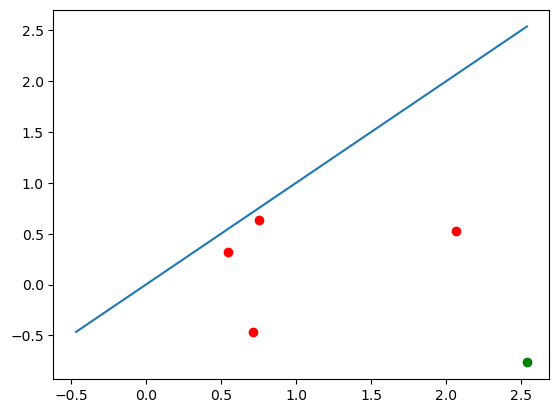

In [66]:
t = Tomato(density_type="logDTM", k=50)  # logDTM
clusters = t.fit_predict(layout_3d_corr)
t.plot_diagram()

In [67]:
print(t.n_clusters_)
# t.n_clusters_ = 3
print(Counter(t.labels_).most_common(10))

5
[(3, 157), (0, 135), (1, 111), (4, 84), (2, 25)]


In [68]:
corr_neurons = [i for i in range(len(t.labels_)) if t.labels_[i] == 2]
print(corr_neurons)

[3, 11, 22, 26, 29, 43, 52, 55, 66, 68, 87, 96, 137, 138, 165, 166, 175, 178, 245, 252, 270, 280, 323, 329, 469]


In [69]:
corr_act = activity[:, corr_neurons]
print(corr_act.shape)

(50761, 25)


In [72]:
layout = UMAP(
    n_components=corr_act.shape[1],
    verbose=True,
    n_neighbors=20,
    min_dist=0.01,
    metric="cosine",
).fit_transform(corr_act)
# M = squareform(pdist(layout2, "euclidean"))

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.01, n_components=25, n_neighbors=20, verbose=True)
Fri Mar 18 10:12:00 2022 Construct fuzzy simplicial set
Fri Mar 18 10:12:00 2022 Finding Nearest Neighbors
Fri Mar 18 10:12:00 2022 Building RP forest with 16 trees
Fri Mar 18 10:12:00 2022 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Fri Mar 18 10:12:01 2022 Finished Nearest Neighbor Search
Fri Mar 18 10:12:01 2022 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Fri Mar 18 10:12:55 2022 Finished embedding


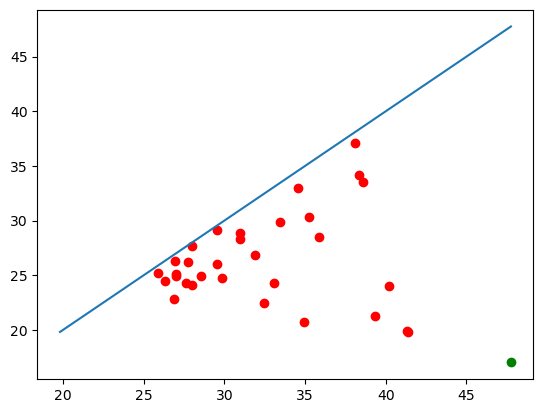

In [73]:
to = Tomato(density_type="logDTM", k=200)  # logDTM, DTM, ‘KDE’ or ‘logKDE’
clusters = to.fit_predict(layout)
to.plot_diagram()

In [75]:
print(to.n_clusters_)
print(Counter(to.labels_).most_common(10))
clusters = to.labels_

32
[(4, 3306), (9, 3250), (16, 2884), (11, 2755), (13, 2728), (6, 2691), (5, 2293), (10, 2211), (2, 2125), (12, 2104)]


In [123]:
cluster = []
for n in range(len(clusters)):
    if clusters[n] in [4]:
        cluster.append(corr_act[n])
cluster = np.array(cluster)
print(cluster.shape)

(3306, 25)


In [124]:
layout2 = UMAP(
    n_components=corr_act.shape[1],
    verbose=True,
    n_neighbors=20,
    min_dist=0.01,
    metric="cosine",
).fit_transform(cluster)
M = squareform(pdist(layout2, "euclidean"))

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.01, n_components=25, n_neighbors=20, verbose=True)
Fri Mar 18 11:17:02 2022 Construct fuzzy simplicial set
Fri Mar 18 11:17:04 2022 Finding Nearest Neighbors
Fri Mar 18 11:17:04 2022 Finished Nearest Neighbor Search
Fri Mar 18 11:17:04 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Fri Mar 18 11:17:08 2022 Finished embedding


In [125]:
maxdim = 1
coeff = 47
thresh = np.max(M[~np.isinf(M)])
persistence = ripser(
    M, maxdim=maxdim, coeff=coeff, do_cocycles=True, distance_matrix=True, thresh=thresh
)

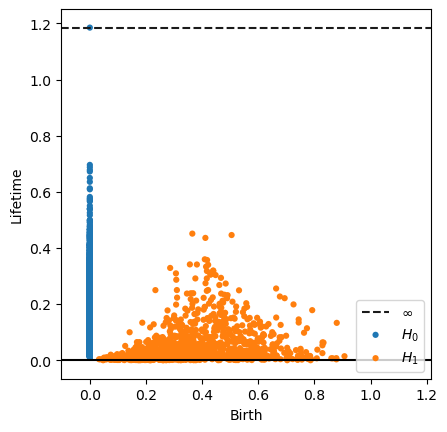

In [126]:
plot_diagrams(persistence["dgms"], lifetime=True, show=True)

In [127]:
diagrams = persistence[
    "dgms"
]  # the multiset describing the lives of the persistence classes
cocycles = persistence["cocycles"][
    1
]  # the cocycle representatives for the 1-dim classes
births1 = diagrams[1][:, 0]  # the time of birth for the 1-dim classes
deaths1 = diagrams[1][:, 1]  # the time of death for the 1-dim classes
lives1 = deaths1 - births1  # the lifetime for the 1-dim classes
iMax = np.argsort(lives1)

circle_num = 1

threshold = births1[iMax[-circle_num]] + (
    deaths1[iMax[-circle_num]] - births1[iMax[-circle_num]]
) * (9 / 10)


f, theta_matrix, verts, num_verts = get_coords(
    cocycle=cocycles[iMax[-circle_num]],
    threshold=threshold,
    num_sampled=len(layout2),
    dists=M,
    coeff=coeff,
    bool_smooth_circle="perea",  # "graph", "old", "perea"
)

number of vertices = 3306
number of edges = 137813


In [128]:
layout_3d = UMAP(
    n_components=3, verbose=True, n_neighbors=20, min_dist=0.01, metric="cosine"
).fit_transform(cluster)

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.01, n_components=3, n_neighbors=20, verbose=True)
Fri Mar 18 11:20:01 2022 Construct fuzzy simplicial set
Fri Mar 18 11:20:03 2022 Finding Nearest Neighbors
Fri Mar 18 11:20:03 2022 Finished Nearest Neighbor Search
Fri Mar 18 11:20:03 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Fri Mar 18 11:20:05 2022 Finished embedding


In [129]:
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=layout_3d[:, 0],
            y=layout_3d[:, 1],
            z=layout_3d[:, 2],
            mode="markers",
            marker=dict(
                size=12, color=f, colorscale="hsv", opacity=0.8, showscale=True
            ),
        )
    ]
)
# Cyclic colors: 'twilight', 'twilight_shifted', 'hsv', Default: Viridis
fig.update_layout(
    autosize=False, width=1000, height=700, margin=dict(l=0, r=0, b=0, t=0)
)
fig.write_html("corr_clustering_1.html")
fig.show()

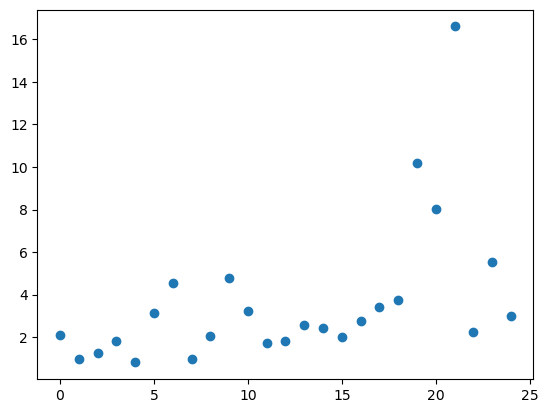

In [104]:
neurons = corr_act.shape[1]
circ_rates = np.zeros([corr_act.shape[1], 50])
counts, bins = np.histogram(f, bins=50, density=True)
for b in range(len(bins) - 1):
    for n in range(corr_act.shape[1]):
        rates = []
        for x in range(len(cluster)):
            if bins[b] < f[x] <= bins[b + 1]:
                rates.append(cluster[x, n])
        if rates:
            circ_rates[n, b] = np.mean(rates)
        else:
            circ_rates[n, b] = 0


def inform_rate(mean_n, data, coun):
    return np.sum(data * np.log2((data / mean_n) + 0.0000001) * coun)


mean = np.mean(cluster, axis=0)

inform_rates = [inform_rate(mean[n], circ_rates[n, :], counts) for n in range(neurons)]

plt.scatter(range(neurons), inform_rates)
plt.show()

In [117]:
inform = 2
high_inform = np.where(np.array(inform_rates) > inform)[0]
print(high_inform)
len(high_inform)

[ 0  5  6  8  9 10 13 14 16 17 18 19 20 21 22 23 24]


17

In [118]:
cluster_new = cluster[:, np.where(np.array(inform_rates) > inform)[0]]
data_new = corr_act[:, np.where(np.array(inform_rates) > inform)[0]]

layout_3d_cluster = UMAP(
    n_components=3, verbose=True, n_neighbors=20, min_dist=0.01, metric="cosine"
).fit_transform(cluster_new)

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.01, n_components=3, n_neighbors=20, verbose=True)
Fri Mar 18 10:33:18 2022 Construct fuzzy simplicial set
Fri Mar 18 10:33:19 2022 Finding Nearest Neighbors
Fri Mar 18 10:33:19 2022 Finished Nearest Neighbor Search
Fri Mar 18 10:33:19 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Fri Mar 18 10:33:21 2022 Finished embedding


In [119]:
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=layout_3d_cluster[:, 0],
            y=layout_3d_cluster[:, 1],
            z=layout_3d_cluster[:, 2],
            mode="markers",
            marker=dict(
                size=12,
                color=f,
                colorscale="hsv",
                opacity=0.8,
                showscale=True,
            ),
        )
    ]
)
fig.update_layout(
    autosize=False, width=1000, height=700, margin=dict(l=0, r=0, b=0, t=0)
)
fig.write_html("correlation_inform.html")
fig.show()

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.01, n_components=11, n_neighbors=20, verbose=True)
Fri Mar 18 10:32:35 2022 Construct fuzzy simplicial set
Fri Mar 18 10:32:37 2022 Finding Nearest Neighbors
Fri Mar 18 10:32:37 2022 Finished Nearest Neighbor Search
Fri Mar 18 10:32:37 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Fri Mar 18 10:32:39 2022 Finished embedding


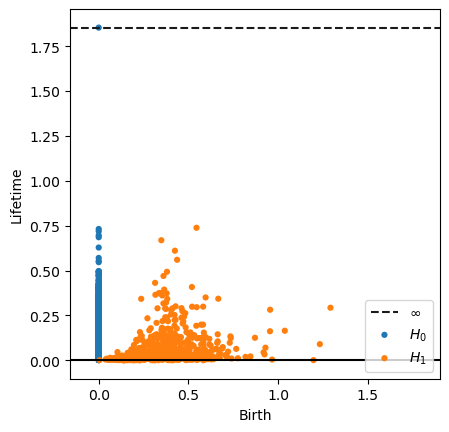

In [116]:
layout3 = UMAP(
    n_components=len(high_inform),
    verbose=True,
    n_neighbors=20,
    min_dist=0.01,
    metric="cosine",
).fit_transform(cluster_new)
M = squareform(pdist(layout3, "euclidean"))
maxdim = 1
coeff = 47
thresh = np.max(M[~np.isinf(M)])
persistence = ripser(
    M, maxdim=maxdim, coeff=coeff, do_cocycles=True, distance_matrix=True, thresh=thresh
)
diagrams = persistence[
    "dgms"
]  # the multiset describing the lives of the persistence classes

plot_diagrams(diagrams, show=True, lifetime=True)
cocycles = persistence["cocycles"][
    1
]  # the cocycle representatives for the 1-dim classes
births1 = diagrams[1][:, 0]  # the time of birth for the 1-dim classes
deaths1 = diagrams[1][:, 1]  # the time of death for the 1-dim classes
lives1 = deaths1 - births1  # the lifetime for the 1-dim classes
iMax = np.argsort(lives1)

threshold = births1[iMax[-1]] + (deaths1[iMax[-1]] - births1[iMax[-1]]) * (9 / 10)

cocycle = cocycles[iMax[-1]]

In [120]:
f_new, theta_matrix, verts_new, num_verts = get_coords(
    cocycle,
    threshold,
    len(layout3),
    M,
    47,
    "perea",  # "graph", "old", "perea"
)

number of vertices = 2755
number of edges = 254370


In [122]:
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=layout_3d_cluster[:, 0],
            y=layout_3d_cluster[:, 1],
            z=layout_3d_cluster[:, 2],
            mode="markers",
            marker=dict(
                size=12,
                color=f_new,
                colorscale="hsv",
                opacity=0.8,
                showscale=True,
            ),
        )
    ]
)
fig.update_layout(
    autosize=False, width=1000, height=700, margin=dict(l=0, r=0, b=0, t=0)
)
fig.write_html("corr_final.html")
fig.show()